Using the learned from CCD01, subsample of days for Y4E1, analyze the other tapebumps

In [1]:
import os
import glob
import time
import numpy as np
import scipy.linalg
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation
import multiprocessing as mp
import astropy.time
# from astropy import time 
import easyaccess as ea
# from skimage import data, img_as_float
from skimage.measure import compare_ssim
from astropy.visualization import (MinMaxInterval, SqrtStretch,
                                   ImageNormalize, ZScaleInterval)
%matplotlib notebook

## Set of Functions

Below, typical sequential (movie-like) plot

```Python
fig = plt.figure()
ims = []
for i in path_list:
    aux_x = np.load(i)
    # Normalize image, using astropy zscale for range, and square root for 
    # stretching (?)
    im_norm = ImageNormalize(aux_x, 
                             interval=ZScaleInterval(),
                             stretch=SqrtStretch())
    # Append each of the plots to a list
    kw  = {
        'origin' : 'lower', 
        'animated' : True, 
        'cmap' : 'gray_r',
    }
    im = plt.imshow(aux_x, norm=im_norm, **kw)
    ims.append([im])
# Using the plot-populated list, create the animation
# blitting (True/False) useful when the frame can be slightly modified to 
# create the next frame
ani = animation.ArtistAnimation(fig, ims, 
                                interval=anim_interval, 
                                blit=True,
                                repeat_delay=1000, 
                                repeat=anim_repeat)
if anim_save:
    if (outfnm is None):
        outfnm = 'pid{0}.mp4'.format(os.getpid())
    # Set up formatting for the movie files
    aux_wr1 = animation.writers['ffmpeg']
    aux_writer = aux_wr1(fps=15, metadata=dict(artist='F Paz-Chinchon'), bitrate=2000, dpi=300)
    ani.save(outfnm, writer=aux_writer)
else:
    plt.show()
```

Function to create the median image

In [2]:
def stat_cube(x3d, func):
    ''' Function to calculate the median image per pixel, using an input 
    3dimensional array containing the stamps on which to work.
    Uses numpy iteration tools
    Example for easy usage:
    x3d = np.dstack(array_i)
    x_median = stat_cube(x3d, (lambda: np.median)())
    '''
    out = np.zeros_like(x3d[:, :, 0])
    it = np.nditer(x3d[:, :, 0], flags=['multi_index'])
    while not it.finished:
        i1, i2 = it.multi_index
        out[i1, i2] = func(x3d[i1, i2, :])
        it.iternext()
    return out

Read stamps in parallel. Alternative method. With mutiprocessing in 4 cores, 4000 files can be read in ~0.5 min. Sower than the async method

In [75]:
def alt_read_stamps(epoch, ccd, tape, b):
    def dload(ls_path):
        i = False
        for p in ls_path:
            if not i:
                tmp = np.load(p)
                i = True
            else:
                tmp = np.dstack((tmp, np.load(p)))
        return tmp
    #
    t0 = time.time()
    pattern = 'work_area/stamps/'
    pattern += 'y4a1_{0}_c{1:02}_{2}_{3}_*'.format(epoch, ccd, tape, b)
    # Iterator to walk through the directory, once used it cannot be reused
    iterat = glob.glob(pattern, recursive=False)
    # Divide the amount of jobs in one per cpu
    ncpu = mp.cpu_count()
    nelem = np.ceil(len(iterat) // ncpu).astype('int')
    iterat_sub = [iterat[v : v + nelem] for v in range(0, len(iterat), nelem)]
    # Set multiprocessing
    P1 = mp.Pool(processes=ncpu)
    res = P1.map(dload, iterat_sub)
    # Stack the arrays returned as elements of the list, over the 
    # 3rd dimension
    dims = 3
    if (len(res) > 1):
        x = res[0]
        for m in res[1:]:
            if np.equal(m.ndim, dims):
                x = np.r_['2, 2', x, m]
            elif np.equal(m.ndim, dims - 1):
                m = np.expand_dims(m, axis=2)
                print(x.shape, m.shape)
                x = np.r_['2, 2', x, m]
            else:
                logging.error('Wrong number of dimensions')
    t1 = time.time()
    print('Elapsed time: {0:.2f}'.format((t1 - t0) / 60))
    return x

Read stamps. The traditional method from `median_image_ccd.py`, using async:

In [86]:
def orig_read_stamps(epoch, ccd, tape, b, sublist_expnum):
    t0 = time.time()
    pattern = 'work_area/stamps/'
    pattern += 'y4a1_{0}_c{1:02}_{2}_{3}_*'.format(epoch, ccd, tape, b)
    # Iterator to walk through the directory, once used it cannot be reused
    iterat_aux = glob.glob(pattern, recursive=False)
    # If sublist_expnum, then only use these exposure numbers
    iterat = [x for x in iterat_aux for e in sublist_expnum if e in x]
    P2 = mp.Pool(processes=mp.cpu_count())
    res_v2 = P2.map_async(np.load, iterat)
    res_v2.wait()
    res_v2 = res_v2.get()
    x_v2 = np.dstack(res_v2)
    t1 = time.time()
    print(x_v2.shape)
    print('Elapsed time: {0:.2f}'.format((t1 - t0) / 60))
    return x_v2

In [79]:
def db_query(q):
    connection = ea.connect('desoper')
    df_qa = connection.query_to_pandas(q)
    return df_qa

## Get it

Get DB quality assessments for the exposures, to construct median image based in time range and in quality of the observation

In [109]:
q1 = 'select qa.expnum, e.nite, qa.t_eff, qa.skybrightness, qa.psf_fwhm, qa.f_eff,'
q1 += ' qa.c_eff, qa.b_eff, qa.skytilt'
q1 += ' from exposure e, qa_summary qa, proctag pt'
q1 += ' where pt.tag=\'Y4A1_FINALCUT\''
q1 += ' and pt.pfw_attempt_id=qa.pfw_attempt_id'
q1 += ' and qa.expnum=e.expnum'
q1 += ' and e.nite between 20160813 and 20161208'
q1 += ' order by qa.expnum'
#
q2 = 'select qa.expnum, e.nite, qa.t_eff, qa.skybrightness, qa.psf_fwhm, qa.f_eff,'
q2 += ' qa.c_eff, qa.b_eff, qa.skytilt'
q2 += ' from exposure e, qa_summary qa, proctag pt'
q2 += ' where pt.tag=\'Y4A1_FINALCUT\''
q2 += ' and pt.pfw_attempt_id=qa.pfw_attempt_id'
q2 += ' and qa.expnum=e.expnum'
q2 += ' and e.nite between 20161209 and 20170102'
q2 += ' order by qa.expnum'
#
db_y4e1 = db_query(q1)
db_y4x1 = db_query(q2)

Connecting to DB ** desoper ** ...
Connecting to DB ** desoper ** ...


*Important: submit already constrained lists to get the median image*

In [112]:
for b in ['u', 'g', 'r', 'i', 'z', 'Y']:
    for sx in ['s' + str(s) for s in range(1, 6 + 1)]:
        pass

In [107]:
# Try with: epoch 1 before oct 18, epoch 1 after oct 18, epoch x1 

epoch, ccd, tape, b = 'y4e1', 1, 's1', 'z', 
sub_exp = ['D00' + str(s) for s in df_y4e1.loc[df_y4e1['nite'] > 20161018, 'expnum']]
tmp_x3d = orig_read_stamps(epoch, ccd, tape, b, sub_exp)
tmp_medimg = stat_cube(tmp_x3d, (lambda: np.median)())

(88, 129, 1802)
Elapsed time: 0.05


Get the files for basic stats

<IPython.core.display.Javascript object>


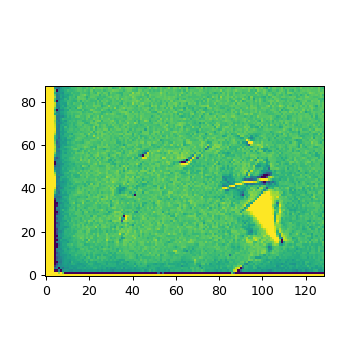

In [108]:
fig, ax = plt.subplots(figsize=(4, 4))
im_norm = ImageNormalize(tmp_medimg, 
                         interval=ZScaleInterval(),
                         stretch=SqrtStretch())
ax.imshow(tmp_medimg, origin='lower', norm=im_norm)

Relate basic statistics of the stamps with the `T_EFF` and `SKYBRIGHTNESS`, looking for some correlation

In [63]:
res[0].shape

aux = np.r_['2,2', res[0], np.expand_dims(res[-1], axis=2)]

TypeError: 'NoneType' object is not callable

In [66]:
np.equal(aux.ndim, 3)

True

In [59]:
np.r_['3, 5, 0', [[11,22],[33,44]], [1,2,3,4], [5,6,7,8], [9,10,11,12]]

ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [44]:
e1_s1 = get_pathlist('y4e1', 1, 's1', 'z')

In [48]:
len(e1_s1[0][1])

1

In [51]:
e1_s1[0][0].shape

(88, 129, 3757)